# The journey to scale
- From Logistic Regressor to Perceptron
- From Perceptron to MLP
- Increasing sequence length

Now:
- *Adding more layers*
- Making sure we can train on so many layers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import LucaM185

# Loading the dataset

In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

# Deeper Network (2 hidden layers)

To get from the perceptron to mlp we expanded the model by scaling the input dimension. Now we can try to make it deeper, with more operations happening in series. <br>


_Curious note: biological neurons fire around 100 times a second, it takes a human 100ms to identify an object, so it stands to reason that a 10 layer network may be able to do complex tasks._

Millions of parameters: 0.08
Epoch ___0 - Loss: 4.170
Epoch _300 - Loss: 2.655
Epoch _600 - Loss: 2.284
Epoch _900 - Loss: 2.128
Epoch 1200 - Loss: 2.015
Epoch 1500 - Loss: 2.001
Epoch 1800 - Loss: 1.932
Epoch 2100 - Loss: 1.881
Epoch 2400 - Loss: 1.823
Epoch 2700 - Loss: 1.819


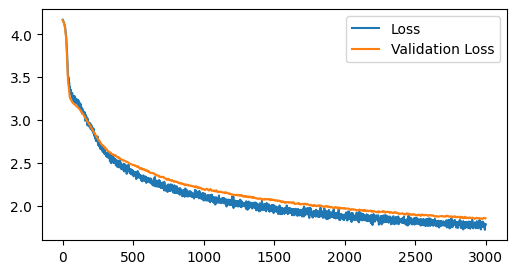

In [6]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) # this is a list of linear layers
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden:    # iterating over hidden layers
            x = F.gelu(hidden(x))  # applying each hidden layer
        return self.fc_out(x)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
model = Model(emb_size=16, hidden_size=128, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Much deeper network (20 layers)

Millions of parameters: 0.38
Epoch ___0 - Loss: 4.154
Epoch _300 - Loss: 2.990
Epoch _600 - Loss: 2.674
Epoch _900 - Loss: 2.495
Epoch 1200 - Loss: 2.413
Epoch 1500 - Loss: 2.385
Epoch 1800 - Loss: 2.346
Epoch 2100 - Loss: 2.290
Epoch 2400 - Loss: 2.276
Epoch 2700 - Loss: 2.376


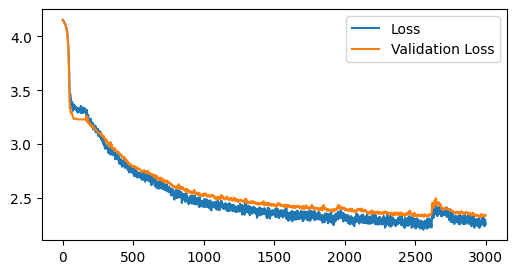

In [7]:
class Model(nn.Module):  # Same model class as before
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden:
            x = F.gelu(hidden(x))
        return self.fc_out(x)


model = Model(emb_size=16, hidden_size=128, n_layers=20).to(device)  # increased to 20 layers 
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

The network with 20 hidden layers is unable to train effectively, thats because the derivatives don't flow well between the layers

# Residual connections

Millions of parameters: 0.38
Epoch ___0 - Loss: 5.687
Epoch _300 - Loss: 2.154
Epoch _600 - Loss: 1.855
Epoch _900 - Loss: 1.741
Epoch 1200 - Loss: 1.679
Epoch 1500 - Loss: 1.602
Epoch 1800 - Loss: 1.573
Epoch 2100 - Loss: 1.528
Epoch 2400 - Loss: 1.489
Epoch 2700 - Loss: 1.436


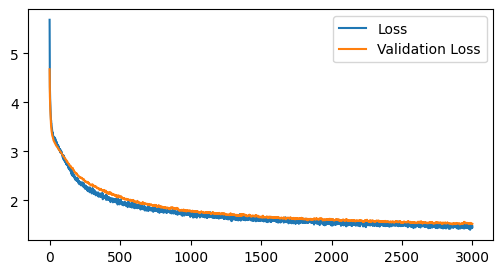

In [8]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden: 
            x = x + F.gelu(hidden(x))  # added skip connection 
        return self.fc_out(x)
    

model = Model(emb_size=16, hidden_size=128, n_layers=20).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

In a standard layer, `x = linear(x)` completely transforms the input, which can make learning identity mappings harder. With residual connections, `x = x + linear(x)`, allowing the network to retain the original input while learning incremental changes. This improves gradient flow, facilitates identity learning, and enhances stability, especially in deep networks.

# Deeper (56 layers) 

Millions of parameters: 0.98
Epoch ___0 - Loss: 8598.361
Epoch _300 - Loss: 3.367
Epoch _600 - Loss: 3.177
Epoch _900 - Loss: 3.081
Epoch 1200 - Loss: 2.943
Epoch 1500 - Loss: 2.829
Epoch 1800 - Loss: 2.702
Epoch 2100 - Loss: 2.614
Epoch 2400 - Loss: 2.455
Epoch 2700 - Loss: 2.373


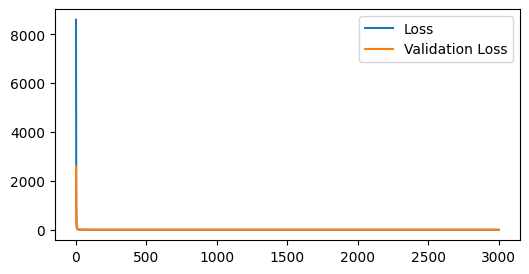

In [9]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden: 
            x = x + F.gelu(hidden(x))  
        return self.fc_out(x)


model = Model(emb_size=16, hidden_size=128, n_layers=56).to(device)  # increased to 56 layers
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Normalization

Deeper networks allow for more layers, but often result in high loss initially. While we previously addressed this by decreasing parameter values at initialization, going too low can cause excessively small values. To prevent this, we normalize the neurons using layer normalization, ensuring a that the model has control over mean and std

In [ ]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.norm = nn.LayerNorm(hidden_size)  # added batch norm

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden: 
            x = x + F.gelu(self.norm(hidden(x)))  
        x = self.norm(x)
        return self.fc_out(x)


model = Model(emb_size=16, hidden_size=128, n_layers=56).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

Millions of parameters: 0.98
Epoch ___0 - Loss: 4.106
Epoch _300 - Loss: 2.092
Epoch _600 - Loss: 1.888
Epoch _900 - Loss: 1.711
Epoch 1200 - Loss: 1.660
Epoch 1500 - Loss: 1.574
Epoch 1800 - Loss: 1.572
Epoch 2100 - Loss: 1.454
Epoch 2400 - Loss: 1.490
Epoch 2700 - Loss: 1.443


In [ ]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(n_layers)])  # added batch norm

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for n, hidden in enumerate(self.fc_hidden): 
            x = x + F.gelu(self.norms[n](hidden(x)))  
        return self.fc_out(x)


model = Model(emb_size=16, hidden_size=128, n_layers=56).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

In [ ]:
string = "             \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    model.eval()
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")
    model.train()


             
KING RICHARD It met Rume to beseech well you with never cause, to thyself answer shore.

PROSPERO:
Unto my in peace out again.

BAPTISTA:
Come, find my should your which in merely;-and I have I save thy head, to long, or friends, this prespetiem.

BRUTUS:
O straited three does and brother,
Feow them feSeijher, wi

finally the text generated from the model makes some sense

# WAYY TOO DEEP
Just for fun lets try way more layers

Millions of parameters: 3.35
Epoch ___0 - Loss: 4.301
Epoch _300 - Loss: 1.887
Epoch _600 - Loss: 1.615
Epoch _900 - Loss: 1.520
Epoch 1200 - Loss: 1.431
Epoch 1500 - Loss: 1.399
Epoch 1800 - Loss: 1.351
Epoch 2100 - Loss: 1.330
Epoch 2400 - Loss: 1.295
Epoch 2700 - Loss: 1.293


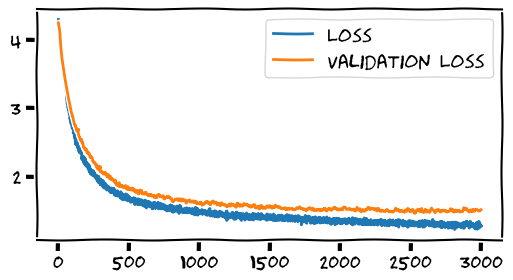

In [ ]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.norm = nn.BatchNorm1d(hidden_size)  

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden: 
            x = x + self.norm(F.gelu(hidden(x)))  
        return self.fc_out(self.norm(x))


model = Model(emb_size=16, hidden_size=128, n_layers=200).to(device)  # increased to 200 layers
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Limits to scale
The performance of the model is not improving in any way, it stands to reason that we are saturating the 20 character sequence length with those big models. We will now explore new ways of increasing sequence length in the next sections